In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import time
import scipy.io as io

import skimage.measure
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint
from keras.models import *
from keras.layers import *
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2

In [ ]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(16)
tf.random.set_seed(16)
random.seed(16)

In [ ]:
mall_gt = io.loadmat(".../heads-position/mall_gt.mat")
mall_head_pos = mall_gt['frame'][0]

# Distribution of people in Mall Dataset

In [ ]:
#Array with the number of people in every image

number_of_people = []

i=0

for img_name in sorted(os.listdir(path = path_frames)):
    i=i+1

    number_of_people.append(len(mall_head_pos[i-1][0][0][0]))

number_of_people = np.asarray(number_of_people)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


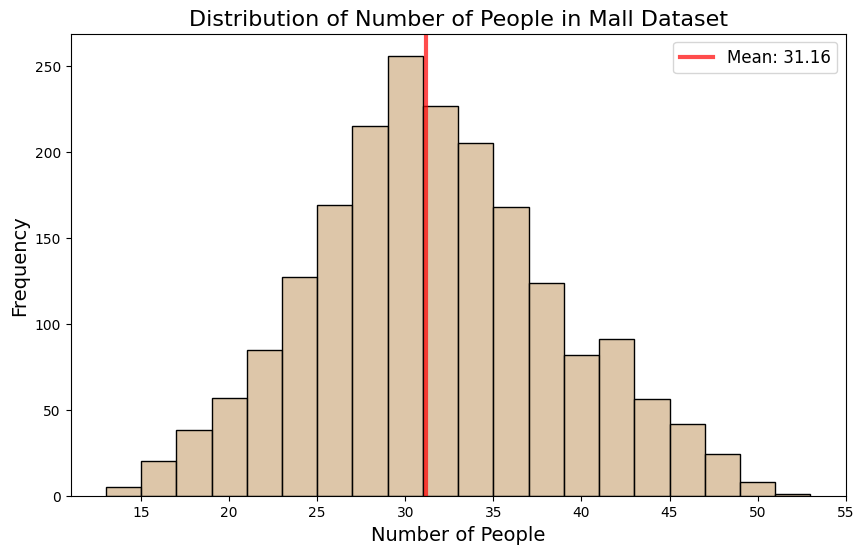

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
sns.histplot(number_of_people, bins=20, color='#D2B48C', edgecolor='black')

mean_value = np.mean(number_of_people)
median_value = np.median(number_of_people)

plt.axvline(mean_value, linewidth=3, color='red', label=f"Mean: {mean_value:.2f}", alpha=0.7)

plt.title('Distribution of Number of People in Mall Dataset', fontsize=16)
plt.xlabel('Number of People', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)

plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


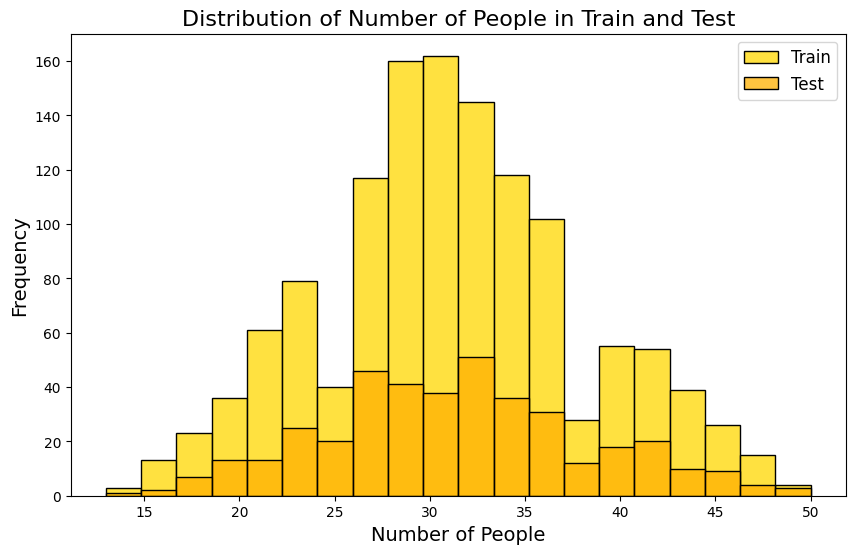

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.histplot(Train_labels, bins=20,color='#FFD700', edgecolor='black',label='Train')
sns.histplot(Test_labels,bins=20, color='#FFB000', edgecolor='black',label='Test')


plt.title('Distribution of Number of People in Train and Test', fontsize=16)
plt.xlabel('Number of People', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)

plt.show()


# Split in Train - Val - Test

In [ ]:
path_frames = '.../frames224/'

img_names = sorted([file for file in os.listdir(path=path_frames) if file.endswith('.jpg')])

test_proportion = 0.2
Train_val_frames_names, Test_frames_names = train_test_split(img_names, test_size=test_proportion, random_state=16)

val_proportion= 0.1
Train_frames_names, Val_frames_names = train_test_split(Train_val_frames_names, test_size=test_proportion, random_state=16)

# Save into array Train Images, Ground Truth and Labels

In [ ]:
Train_imgs = []
Train_labels = []

i=0

for img_name in sorted(os.listdir(path = path_frames)):
    i=i+1
    if img_name in Train_frames_names:
        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Train_imgs.append(img)
        Train_labels.append(len(mall_head_pos[i-1][0][0][0]))

Train_imgs = np.asarray(Train_imgs)
Train_labels = np.asarray(Train_labels)

# Save into array Validation Images, Ground Truth and Labels

In [ ]:
Val_imgs = []
Val_labels = []

i=0

for img_name in sorted(os.listdir(path = path_frames)):
    i=i+1
    if img_name in Val_frames_names:
        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Val_imgs.append(img)
        Val_labels.append(len(mall_head_pos[i-1][0][0][0]))

Val_imgs = np.asarray(Val_imgs)
Val_labels = np.asarray(Val_labels)

# Save into array Test Images, Ground Truth and Labels

In [ ]:
Test_imgs = []
Test_labels = []

i=0

for img_name in sorted(os.listdir(path = path_frames)):
    i=i+1
    if img_name in Test_frames_names:
        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Test_imgs.append(img)
        Test_labels.append(len(mall_head_pos[i-1][0][0][0]))

Test_imgs = np.asarray(Test_imgs)
Test_labels  = np.asarray(Test_labels)

# Model Definition

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # change here the model name

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='relu')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, decay=5e-4), loss="mse", metrics=["mae"])
#model.compile(optimizer=Adam(learning_rate=1e-5), loss="mae", metrics=["mae"])

checkpoint_filepath = './resnet_crowd_counting.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=1)

history = model.fit(Train_imgs, Train_labels,
                    batch_size=16 , epochs=100,
                    validation_data=(Val_imgs, Val_labels),
                    callbacks=[model_checkpoint_callback])

model.save('resnet_crowd_counting_final.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
 2/80 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 932.4597 - mae: 29.8694  

I0000 00:00:1720871093.869874   56558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 396.2493 - mae: 16.4369
Epoch 1: val_mae improved from inf to 6.67398, saving model to ./resnet_crowd_counting.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - loss: 393.3816 - mae: 16.3437 - val_loss: 70.7073 - val_mae: 6.6740
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 9.4230 - mae: 2.4114
Epoch 2: val_mae improved from 6.67398 to 4.98320, saving model to ./resnet_crowd_counting.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 9.3906 - mae: 2.4067 - val_loss: 42.3088 - val_mae: 4.9832
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.8543 - mae: 1.5824
Epoch 3: val_mae improved from 4.98320 to 4.76975, saving model to ./resnet_crowd_counting.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.8474 - mae: 1.5808 - val_loss: 38.9134 - val_mae: 4.7698
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.8043 - mae: 1.3862
Epoch 4: val_mae improved from 4.76975 to 4.63421, saving

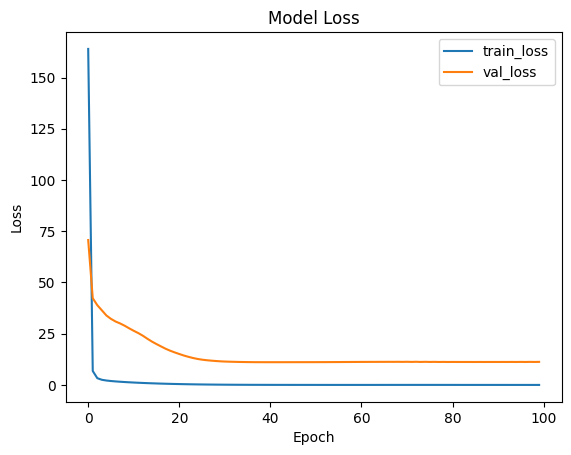

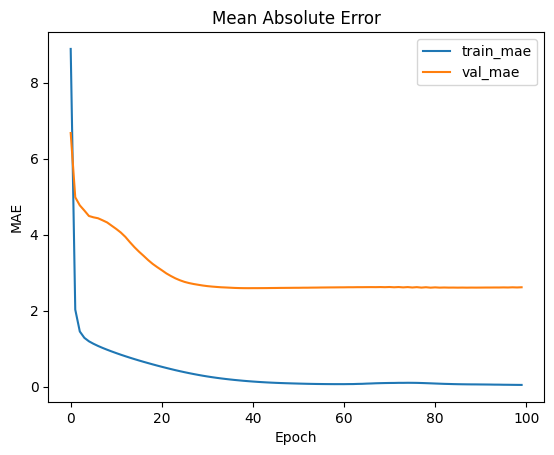

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Test Values

In [ ]:
def test_model(model, Test_imgs, Test_labels, file_parameters_path):
    model.load_weights(file_parameters_path)

    mae_error = 0
    mse_error = 0
    mape_error = 0


    N = len(Test_labels)
    for i, (x, y) in enumerate(zip(Test_imgs, Test_labels)):

        print(i)

        mae_error += np.abs(np.sum(model.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y)
        mse_error += np.square(np.sum(model.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y)
        mape_error += np.abs((np.sum(model.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y) / y)* 100

    return mae_error/N, np.sqrt(mse_error/N), mape_error/N

mae, mse, mape  = test_model(model, Test_imgs, Test_labels, checkpoint_filepath)
print(f"Mean Absolute Error: {mae}, Mean Square Error: {mse}, Mean Absolute Percentage Error:{mape}")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/s